# Imports & Configurations

In [79]:
# Import packages
from vcodatools.db.conn import StarburstConnection

import trino


from sqlalchemy import text


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *

# Show all the columns when displaying a dataframe
pd.set_option("display.max_columns", None)

In [80]:
# Seaborn/matplotlib plot settings
sns.set_theme(
    context="notebook",
    style="darkgrid",
    palette="pastel",
)

# Connect to Starburst and Query Data

In [81]:
# database here is Starburst Catalog. Can be set to None and specified in query text.
sb = StarburstConnection(database=None)
con = sb.engine.connect()

In [82]:
# Query for data
query = """
SELECT 
    incurred_org, 
    task_carrying_out_org, 
    expenditure_comment, 
    expenditure_category, 
    item_description, 
    comments, 
    expenditure_item_date,
    expenditure_type_code, 
    accrued_revenue, 
    adjusted_revenue, 
    forecast_revenue, 
    bill_amount, 
    burden_cost, 
    cost_accrual, 
    labor_cost_multiplier, 
    project_name, 
    project_number, 
    project_type, 
    product_line, 
    product_line_desc, 
    task_name, 
    task_number, 
    regular_time, 
    sick_time, 
    holiday_time, 
    floating_holiday_time,
    vacation_time, 
    funeral_leave_time, 
    jury_duty_time, 
    other_time
FROM 
    oracle.oracle_views.all_expenditure_items
WHERE 
    expenditure_category != 'Materials' AND 
    (project_number LIKE '0001929' OR 
    project_number LIKE '0001899' OR 
    project_number LIKE '0001949')
ORDER BY 
    expenditure_item_date

"""

# Initial Cleaning

In [83]:
# Query and store in datetime-indexed data frame
df = pd.read_sql_query(sql=text(query), con=con)
df = df.set_index("expenditure_item_date")

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 637964 entries, 2019-05-08 to 2024-06-21
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   incurred_org           637964 non-null  object 
 1   task_carrying_out_org  637964 non-null  object 
 2   expenditure_comment    173251 non-null  object 
 3   expenditure_category   637964 non-null  object 
 4   item_description       56180 non-null   object 
 5   comments               0 non-null       object 
 6   expenditure_type_code  637964 non-null  object 
 7   accrued_revenue        0 non-null       object 
 8   adjusted_revenue       0 non-null       object 
 9   forecast_revenue       0 non-null       object 
 10  bill_amount            0 non-null       object 
 11  burden_cost            637964 non-null  float64
 12  cost_accrual           0 non-null       object 
 13  labor_cost_multiplier  0 non-null       object 
 14  project_name        

In [85]:
# Quick look at quantitative variables summary statistics
df.describe()

,burden_cost,regular_time,sick_time,holiday_time,floating_holiday_time,vacation_time,funeral_leave_time,jury_duty_time,other_time
count,6.379640e+05,6.379640e+05,637964.0,637964.0,637964.0,637964.0,637964.0,637964.0,637964.0
mean,1.786810e+02,3.723037e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,6.516515e+03,5.691084e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-1.070000e+06,-1.070000e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.500000e-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,2.694000e+01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.498000e+02,7.500000e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.070000e+06,1.070000e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
# Add month feature
df["month"] = df.index.month

# Add day of week feature
df["day_of_week"] = df.index.dayofweek

In [87]:
# Set aside subcontractor expenditures
subcontract_expends = df[df["expenditure_category"] == "Subcon"]
df = df[df["expenditure_category"] != "Subcon"]

# Set aside subcontractor expenditures
subcontract_expends = df[df["expenditure_category"] == "Temp Labor"]
df = df[df["expenditure_category"] != "Temp Labor"]

In [88]:
# All "Mfg Xfer" expenditures have a comment.
print(
    "Mfg Xfer Expenditures without a comment:",
    df[df["expenditure_category"] == "Mfg Xfer"]["expenditure_comment"].isnull().sum(),
)
# These are the comments
df[df["expenditure_category"] == "Mfg Xfer"]["expenditure_comment"].value_counts()

Mfg Xfer Expenditures without a comment: 0


expenditure_comment
MECHANICAL ASSEMBLY RANGE                                                                                                                                     10677
CHANNEL,STRUT,1-5/8IN X 1-5/8IN X 10FT LG,12 GAGE,3IN LONG SLOTTED HOLES,FNSH HOT GALV,ROHS                                                                     239
MANUFACTURING TECHNICIAN RANGE                                                                                                                                   67
ASSY, ANTENNA CONTROL UNIT, AC4100+                                                                                                                              64
ASSY, ENCLOSURE, DISTRIBUTION BOX                                                                                                                                63
                                                                                                                                                              ..

In [89]:
# Dropping Mfg Xfer expenditures
df = df[df["expenditure_category"] != "Mfg Xfer"]

Not sure what these Reclasses exactly mean, but these seem to be related to manufacturing (Mfg) and not labor. Dropping Mfg Xfer expenditures thusly.

- Sick/Holiday/Vacation/Funeral/Jury Duty/Other Time are all 0 arrays. Additionally, some columns have the same value/null for all rows. We will drop them.
- Expenditure items range from May 8, 2019 to June 7, 2024. They are likely ongoing projects.
- Additionally we will add a column for the day of the week, which may be useful in our future analysis.
- Burden cost and regular time rise lots of questions, which we will explore after a bit more cleaning.
- Month and day of week columns added for future analysis
- Subcontractor/temp labor expenditures set aside to a separate dataframe.
- Mfg Xfer expenditures dropped because they aren't labor related expenditures.

In [90]:
# Drop NA columns
df.dropna(axis=1, how="all", inplace=True)

# Drop 0 columns & columns with all the same value
df = df.loc[:, df.nunique() > 1]

In [91]:
print(f"""# Rows: {df.shape[0]}\n# Columns: {df.shape[1]}""")

# Rows: 624273
# Columns: 13


In [92]:
# Check to see if expenditure_type_code starts with '6 - ' (it does)""
print(np.all(df["expenditure_type_code"].str.split("6 - ").str[0] == "6 - "))

# Removing the '6 - '
df.loc[:, "expenditure_type_code"] = (
    df["expenditure_type_code"].str.split("6 - ").str[1]
)

False


_____ rows seems like a lot for just labor items, and from skimming through the dataset earlier we have reasonable suspicion that some rows represent material and overhead costs. 
Let's look further starting with the expenditure category

In [93]:
df["expenditure_category"].value_counts()

expenditure_category
Burden    303758
Labor     184259
Fringe    114437
ODC        21819
Name: count, dtype: int64

TODO: Take a closer look at how subcontracted expenditures fit into the business problem?

In [94]:
labor = df[df["expenditure_category"] == "Labor"]
burden = df[df["expenditure_category"] == "Burden"]
fringe = df[df["expenditure_category"] == "Fringe"]

In [95]:
burden["expenditure_type_code"].value_counts()

expenditure_type_code
Eng Overhead     93598
Eng Ovhd Depr    93482
Mtl Overhead     58033
Ops Ovhd Depr    21880
Ops Overhead     21879
Mfg Overhead     12012
Mtl Ovhd Depr     2874
Name: count, dtype: int64

In [96]:
labor["expenditure_type_code"].value_counts()

expenditure_type_code
Eng Labor             142970
Ops Labor              31240
Eng Lbr Accrued         8598
Ops Lbr Accrued         1444
Mtl Handling Labor         7
Name: count, dtype: int64

- Burden expenditures consists of overhead and overhead depreciation for engineering, operations, and material.
- Labor expenditures consists of engineering, operations, and material handling labor. It also includes *accrued* labor for engineering and operations. What does that mean?

In [97]:
accrued_labor = labor[
    (labor["expenditure_type_code"] == "6 - Eng Lbr Accrued")
    | (labor["expenditure_type_code"] == "6 - Ops Lbr Accrued")
]

In [98]:
unaccrued_labor = labor[
    (labor["expenditure_type_code"] != "6 - Eng Lbr Accrued")
    & (labor["expenditure_type_code"] != "6 - Ops Lbr Accrued")
]

In [99]:
accrued_labor[~accrued_labor["expenditure_comment"].isna()][
    "expenditure_comment"
].value_counts()

Series([], Name: count, dtype: int64)

The accrued expenditure type code seems to have to do with the submitted or working status of a timecard.

In [100]:
# Quick peek at the expenditures with an item description
item_desc_df = df[~df["item_description"].isnull()]
item_desc_df.head()

,incurred_org,expenditure_comment,expenditure_category,item_description,expenditure_type_code,burden_cost,project_name,project_number,task_name,task_number,regular_time,month,day_of_week
expenditure_item_date,,,,,,,,,,,,,
2019-09-12,75,None,Burden,CONN PLUG COMBICON 3.81 PITCH 4-POS,Mtl Overhead,0.14,Thunderbolt,0001899,MVP Materials,1.01.03.03,0.0,9,3
2019-09-25,75,"CONN BLOCK COMBICON, DIN RAIL 4 PIN",Burden,"CONN BLOCK COMBICON, DIN RAIL 4 PIN",Mtl Overhead,1.09,Thunderbolt,0001899,Material Default,9.99.99,0.0,9,2
2019-09-25,75,"SCREW,SET, EXTENDED POINT,18-8 SST, 1/4-20 X ....",Burden,"SCREW,1/4-20 UNC-3A X 0.500IN LG,SET HALF DOG ...",Mtl Overhead,0.09,Thunderbolt,0001899,Material Default,9.99.99,0.0,9,2
2019-09-25,75,CONN PLUG COMBICON 3.81 PITCH 8-POS,Burden,CONN PLUG COMBICON 3.81 PITCH 8-POS,Mtl Overhead,0.37,Thunderbolt,0001899,Material Default,9.99.99,0.0,9,2
2019-09-25,75,"TUBING,POLYESTER EXPANDABLE 1/2 INCH,BLK,ROHS",Burden,"TUBING,POLYESTER EXPANDABLE 1/2 INCH,BLK,1:3 S...",Mtl Overhead,0.29,Thunderbolt,0001899,Material Default,9.99.99,0.0,9,2


In [101]:
# Check which "organization(s)" that incurr these expenditures
item_desc_df["incurred_org"].value_counts()

incurred_org
75    54751
Name: count, dtype: int64

In [102]:
# Check which expenditure categories these expenditures span
item_desc_df["expenditure_category"].value_counts()

expenditure_category
Burden    54751
Name: count, dtype: int64

In [103]:
# Check expenditure types
item_desc_df["expenditure_type_code"].value_counts()

expenditure_type_code
Mtl Overhead    53300
Mfg Overhead     1451
Name: count, dtype: int64

It looks like rows with an item description represent material costs, and are unrelated to labor. We will drop these drops for the future analysis.

In [104]:
# Drop item description rows, and item_description column
df = df[df["item_description"].isnull()]


df = df.drop("item_description", axis=1)

All of those rows were incurred to the organization '75'. Let's investigate this organization:

In [105]:
org_75 = df[df["incurred_org"] == "75"]

In [106]:
df["project_name"].value_counts()

project_name
Thunderbolt           378068
Swordfish Antennas    126812
Riptide                64642
Name: count, dtype: int64

In [107]:
df[df["expenditure_comment"].str.lower().str.contains("per diem", na=False)]

,incurred_org,expenditure_comment,expenditure_category,expenditure_type_code,burden_cost,project_name,project_number,task_name,task_number,regular_time,month,day_of_week
expenditure_item_date,,,,,,,,,,,,
2022-04-20,75,Per Diem Costs for Destack,ODC,Outside Services,17390.00,Swordfish Antennas,0001929,Matl & Ops Mgmt,2100,17390.00,4,2
2022-06-20,75,Estimated Per Diem,ODC,Outside Services,14880.00,Swordfish Antennas,0001929,Installation,4200,14880.00,6,0
2022-07-17,75,Estimated Per Diem,ODC,Outside Services,-10560.00,Swordfish Antennas,0001929,Installation,4200,0.00,7,6
2022-07-17,75,Estimated Per Diem,ODC,Outside Services,-24000.00,Swordfish Antennas,0001929,Installation,4200,-24000.00,7,6
2022-07-17,75,Estimated Per Diem,ODC,Outside Services,24000.00,Swordfish Antennas,0001929,Installation,4200,24000.00,7,6
2022-07-17,75,Estimated Per Diem,ODC,Outside Services,10560.00,Swordfish Antennas,0001929,Installation,4200,0.00,7,6
2022-07-17,75,Estimated Per Diem,ODC,Outside Services,13440.00,Swordfish Antennas,0001929,Installation,4200,13440.00,7,6
2022-08-07,Eng - AS,Per Diem,ODC,Travel - Meals,24.00,Swordfish Antennas,0001929,Installation,4200,24.00,8,6
2022-08-15,75,Estimated Per Diem,ODC,Outside Services,49.05,Swordfish Antennas,0001929,Installation,4200,49.05,8,0


In [108]:
org_75[org_75["expenditure_type_code"] == "Travel - Meals"]

,incurred_org,expenditure_comment,expenditure_category,expenditure_type_code,burden_cost,project_name,project_number,task_name,task_number,regular_time,month,day_of_week
expenditure_item_date,,,,,,,,,,,,
2022-11-04,75,"9079780, RECLASSED",ODC,Travel - Meals,86.94,Riptide,0001949,Installation,4200,86.94,11,4
2023-09-17,75,Meals & Incidentals\t8 folks for 252 days @ $7...,ODC,Travel - Meals,17551.21,Thunderbolt,0001899,Travel,1.04.11.01.01,17551.21,9,6
2023-11-26,75,Meals & Incidentals\t8 folks for 252 days @ $7...,ODC,Travel - Meals,4204.79,Thunderbolt,0001899,Travel,1.04.11.01.01,4204.79,11,6
2023-11-26,75,Meals & Incidentals\t8 folks for 252 days @ $7...,ODC,Travel - Meals,-4204.79,Thunderbolt,0001899,Travel,1.04.11.01.01,-4204.79,11,6
2024-03-08,75,Per Diem (Qty 3 Labor resources x 65 site day...,ODC,Travel - Meals,6324.00,Thunderbolt,0001899,Travel,1.04.11.01.01,6324.00,3,4
2024-03-27,75,Per Diem (Qty 3 Labor resources x 65 site day...,ODC,Travel - Meals,5580.00,Thunderbolt,0001899,Travel,1.04.11.01.01,5580.00,3,2
2024-04-11,75,Additional 4th Per Diem (Qty 1 Labor resource...,ODC,Travel - Meals,5456.00,Thunderbolt,0001899,Travel,1.04.11.01.01,5456.00,4,3
2024-04-11,75,Per Diem (Qty 3 Labor resources x 65 site day...,ODC,Travel - Meals,5208.00,Thunderbolt,0001899,Travel,1.04.11.01.01,5208.00,4,3
2024-04-21,75,Per Diem (Qty 8 Labor resources supporting 10...,ODC,Travel - Meals,18104.00,Thunderbolt,0001899,Travel,1.04.11.01.01,18104.00,4,6


In [109]:
org_75[org_75["expenditure_type_code"] == "Travel - Meals"]

,incurred_org,expenditure_comment,expenditure_category,expenditure_type_code,burden_cost,project_name,project_number,task_name,task_number,regular_time,month,day_of_week
expenditure_item_date,,,,,,,,,,,,
2022-11-04,75,"9079780, RECLASSED",ODC,Travel - Meals,86.94,Riptide,0001949,Installation,4200,86.94,11,4
2023-09-17,75,Meals & Incidentals\t8 folks for 252 days @ $7...,ODC,Travel - Meals,17551.21,Thunderbolt,0001899,Travel,1.04.11.01.01,17551.21,9,6
2023-11-26,75,Meals & Incidentals\t8 folks for 252 days @ $7...,ODC,Travel - Meals,4204.79,Thunderbolt,0001899,Travel,1.04.11.01.01,4204.79,11,6
2023-11-26,75,Meals & Incidentals\t8 folks for 252 days @ $7...,ODC,Travel - Meals,-4204.79,Thunderbolt,0001899,Travel,1.04.11.01.01,-4204.79,11,6
2024-03-08,75,Per Diem (Qty 3 Labor resources x 65 site day...,ODC,Travel - Meals,6324.00,Thunderbolt,0001899,Travel,1.04.11.01.01,6324.00,3,4
2024-03-27,75,Per Diem (Qty 3 Labor resources x 65 site day...,ODC,Travel - Meals,5580.00,Thunderbolt,0001899,Travel,1.04.11.01.01,5580.00,3,2
2024-04-11,75,Additional 4th Per Diem (Qty 1 Labor resource...,ODC,Travel - Meals,5456.00,Thunderbolt,0001899,Travel,1.04.11.01.01,5456.00,4,3
2024-04-11,75,Per Diem (Qty 3 Labor resources x 65 site day...,ODC,Travel - Meals,5208.00,Thunderbolt,0001899,Travel,1.04.11.01.01,5208.00,4,3
2024-04-21,75,Per Diem (Qty 8 Labor resources supporting 10...,ODC,Travel - Meals,18104.00,Thunderbolt,0001899,Travel,1.04.11.01.01,18104.00,4,6


In [110]:
df[(df["expenditure_comment"].str.lower().str.contains("reclassed", na=False))].head()

,incurred_org,expenditure_comment,expenditure_category,expenditure_type_code,burden_cost,project_name,project_number,task_name,task_number,regular_time,month,day_of_week
expenditure_item_date,,,,,,,,,,,,
2021-02-12,75,"Program Management per SOW paragraph 3.0, RECL...",ODC,Outside Services,16650.00,Riptide,0001949,Material & Ops Mgmt,2100,16650.00,2,4
2021-04-19,75,"NRE for Line Item 1, RECLASSED",ODC,Outside Services,16650.00,Riptide,0001949,Material & Ops Mgmt,2100,16650.00,4,0
2021-04-19,75,"NRE for Line Item 1, RECLASSED",ODC,Outside Services,-29875.00,Riptide,0001949,Material & Ops Mgmt,2100,-29875.00,4,0
2021-04-19,75,"NRE for Line Item 1, RECLASSED",ODC,Outside Services,29875.00,Riptide,0001949,Material & Ops Mgmt,2100,29875.00,4,0
2021-05-31,75,"21010.02, TRAVE - OTHER, RECLASSED",ODC,Travel - Other,6528.99,Riptide,0001949,Material & Ops Mgmt,2100,6528.99,5,0


In [111]:
def duplicate_counts(df):
    dated_df = df.reset_index()

    total_duplicates = np.sum(dated_df.duplicated(keep=False))

    print(f"Rows that have duplicates {total_duplicates}")

    duplicates = dated_df[dated_df.duplicated(keep=False)]
    grouped_duplicates = dated_df.groupby(
        duplicates.columns.to_list(), as_index=False, dropna=False
    )

    dupe_counts = grouped_duplicates.size().sort_values("size", ascending=False)
    dupe_counts = dupe_counts[dupe_counts["size"] > 1]

    return dupe_counts


# Count rows that have a duplicate
duplicate_counts(df)

Rows that have duplicates 13120


,expenditure_item_date,incurred_org,expenditure_comment,expenditure_category,expenditure_type_code,burden_cost,project_name,project_number,task_name,task_number,regular_time,month,day_of_week,size
554776,2024-05-01,Eng - GSN Dev Eng Mech-EE-RF Government,NaN,ODC,Travel - Meals,124.00,Thunderbolt,0001899,Travel,1.04.11.01.01,124.00,5,2,33
554757,2024-05-01,Eng - GSN Dev Eng Mech-EE-RF Government,Travel to Guam for Thunderbolt site 2 install...,ODC,Travel - Hotel,159.00,Thunderbolt,0001899,Travel,1.04.11.01.01,159.00,5,2,32
554756,2024-05-01,Eng - GSN Dev Eng Mech-EE-RF Government,Travel to Guam for Thunderbolt site 2 install...,ODC,Travel - Hotel,120.72,Thunderbolt,0001899,Travel,1.04.11.01.01,120.72,5,2,32
498031,2023-09-26,Ops - AS Manufacturing,SGS MANUFACTURING 0/H 75,Burden,Mfg Overhead,1657.45,Thunderbolt,0001899,24m Reflector WIP,1.01.01.01.02.01.01,0.00,9,1,16
221069,2021-06-21,Ops - AS Manufacturing SC/QA,SGS MANUFACTURING 0/H 75,Burden,Mfg Overhead,4.46,Riptide,0001949,Material & Ops Mgmt,2100,0.00,6,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211201,2021-05-28,Eng - AS,NaN,Burden,Eng Overhead,352.10,Riptide,0001949,Project Engineer,1120,0.00,5,4,2
54329,2020-01-25,Eng - AS,NaN,Labor,Eng Labor,0.00,Thunderbolt,0001899,LM Tech Support,1.03.01.04,0.00,1,5,2
559544,2024-05-31,Eng - AS,NaN,Burden,Eng Overhead,296.38,Thunderbolt,0001899,Indoor Equip-ViaCtrl,1.01.05.01.06,0.00,5,4,2
336164,2022-05-30,Eng - AS,NaN,Labor,Eng Labor,0.00,Thunderbolt,0001899,S-Band Feed Design,1.01.01.04.01.01.04,0.00,5,0,2


<Axes: title={'center': 'Expenditures by Project'}, xlabel='Project Name', ylabel='Density'>

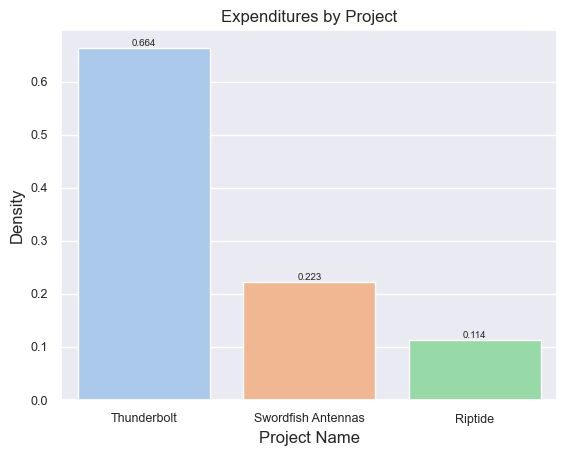

In [112]:
plot_value_counts_density(
    grouped_counts=df["project_name"].value_counts(normalize=True),
    xlabel="Project Name",
    ylabel="Density",
    title="Expenditures by Project",
    xticklabel_rotation=0,
)

In [113]:
thunderbolt = df[df["project_name"] == "Thunderbolt"]
swordfish = df[df["project_name"] == "Swordfish Antennas"]
riptide = df[df["project_name"] == "Riptide"]

program_names = ["Thunderbolt", "Swordfish", "Riptide"]
program_dfs = [thunderbolt, swordfish, riptide]

for program, program_df in zip(program_names, program_dfs):
    print(
        f"{program} expenditure date range: {program_df.index.min().date()} to {program_df.index.max().date()} ({(program_df.index.max() - program_df.index.min()).days} days)"
    )

Thunderbolt expenditure date range: 2019-05-08 to 2024-06-21 (1871 days)
Swordfish expenditure date range: 2020-01-06 to 2024-06-21 (1628 days)
Riptide expenditure date range: 2020-04-13 to 2024-06-17 (1526 days)


# Univariate Analysis (mostly)
*Sometimes I dug a bit further with other columns*

In [114]:
# Organizations (teams) that incurr the expenditures
print(f"# of unique incurred orginizations: {df['incurred_org'].nunique()}")
df["incurred_org"].value_counts(normalize=True)

# of unique incurred orginizations: 57


incurred_org
Eng - AS                                    0.579832
Ops - AS Operations Management              0.069655
Eng - Configuration Management              0.040042
Ops - QA Prod Carlsbad                      0.039863
Ops - AS Manufacturing                      0.038934
Eng - Strategic Technology                  0.038081
Eng - Arizona                               0.028419
Eng - Cyber                                 0.017912
Ops - AS Manufacturing SC/QA                0.016314
SGS                                         0.014131
Eng - Com Configuration Mgmt                0.013640
Eng - Com Quality Assurance                 0.013583
Ops - Business Operations                   0.012814
Eng - Program Control Analysts              0.012266
Eng - Design Quality Assurance              0.010042
75                                          0.007780
Eng - Mechanical & EMI/EMC                  0.007554
Eng - Comsat                                0.005793
Ops - VP Carlsbad                

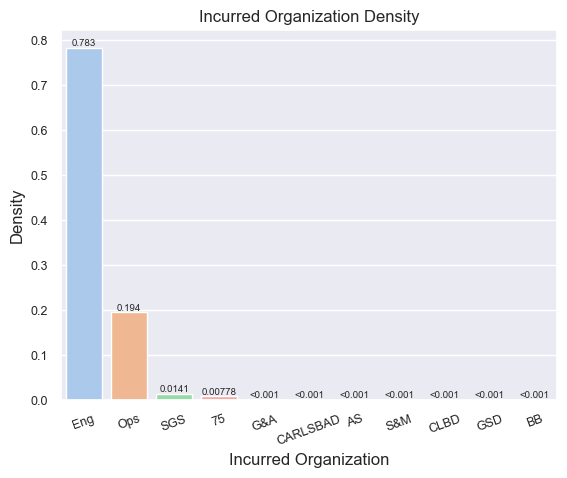

In [115]:
incurred_org_grouped = (
    df["incurred_org"].str.split(" ").str[0].value_counts(normalize=True)
)

ax = plot_value_counts_density(
    grouped_counts=incurred_org_grouped,
    xlabel="Incurred Organization",
    title="Incurred Organization Density",
    barlabel_fontsize=7,
    xticklabel_fontsize=9,
    xticklabel_rotation=20,
    barlabel_show_threshold=0.001,
)

plt.show()

TODO: Find out what all these acronyms mean and which ones matter/don't

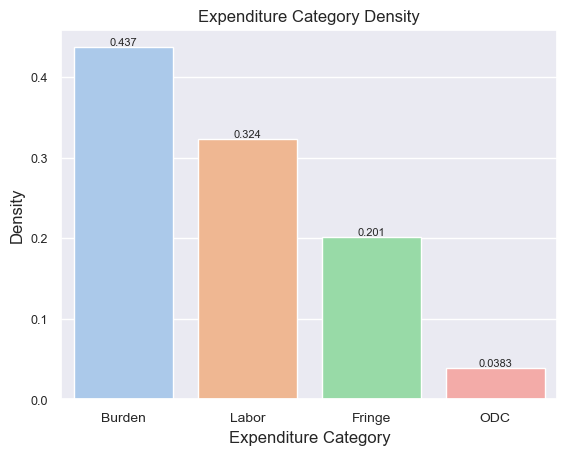

In [116]:
expenditure_category_grouped = df["expenditure_category"].value_counts(normalize=True)

ax = plot_value_counts_density(
    grouped_counts=expenditure_category_grouped,
    xlabel="Expenditure Category",
    title="Expenditure Category Density",
    barlabel_fontsize=8,
    xticklabel_fontsize=10,
    xticklabel_rotation=0,
)

plt.show()

In [117]:
ODC_expenditure_types = df[df["expenditure_category"] == "ODC"][
    "expenditure_type_code"
].value_counts()
ODC_expenditure_types

expenditure_type_code
Travel - Other                  6632
Travel - Hotel                  4755
Travel - Meals                  3533
Outside Services                1078
Other ODC                       1066
Equip - Rentals                  855
Indirect Lab Supplies            743
Travel - Airline                 731
Freight  Out                     626
ODC - Supplies                   553
Hotel - Unallowable              456
Meals - Unallowable              373
Travel - Other - Unallowable     331
Other - Unallowable               45
Transfers - with burden           20
Airfare - Unallowable             16
Consulting                         6
Name: count, dtype: int64

ODC - "Other Direct Costs" is my best guess (with the help of google). Include travel expenses, special tooling and test equipment, consultant services, etc. They are not treated as direct material or direct labor costs, but may be interesting to look at nonetheless.

In [118]:
# Isolate the main category for ODC expenditure codes.
ODC_expenditure_type_simple = ODC_expenditure_types
ODC_expenditure_type_simple.index = ODC_expenditure_type_simple.index.str.split(
    " - "
).str[0]

# Rename some categories for clarity
ODC_expenditure_type_simple.index = (
    ODC_expenditure_type_simple.index.to_series().replace(
        {
            "Equip": "Equipment Rentals",
            "Indirect Lab Supplies": "Indirect Lab Supps",
            "ODC": "ODC Supplies",
            "Transfers": "Transfers w/ burden",
        }
    )
)

# Combine Other - Unallowable and Other ODC
ODC_expenditure_type_simple.iloc[5] += ODC_expenditure_type_simple.iloc[-4]
ODC_expenditure_type_simple = ODC_expenditure_type_simple.drop("Other", axis=0)

# Group by types and aggregate for density
ODC_total = ODC_expenditure_type_simple.sum()
ODC_expenditure_type_grouped = (
    ODC_expenditure_type_simple.groupby("expenditure_type_code")
    .agg(lambda s: sum(s) / ODC_total)
    .sort_values(ascending=False)
)

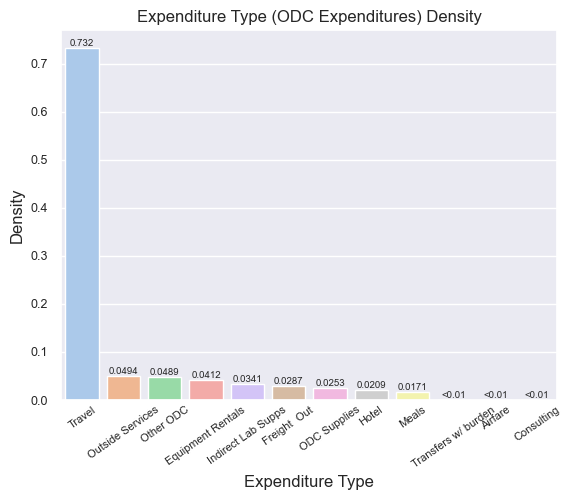

In [119]:
ax = plot_value_counts_density(
    grouped_counts=ODC_expenditure_type_grouped,
    xlabel="Expenditure Type",
    title="Expenditure Type (ODC Expenditures) Density",
    barlabel_fontsize=7,
    xticklabel_fontsize=8,
    xticklabel_rotation=35,
)

ax.set_xticklabels(
    labels=ax.get_xticklabels(), fontsize=8, rotation=35, va="top", y=0.023
)

plt.show()

In [120]:
df[df["expenditure_category"] == "Fringe"]["task_name"].value_counts()

task_name
Configuration Mgmt      2849
Matl & Ops Mgmt         2791
Operations Mgmt         2684
24m Tiger Team Sppt     2288
Positioner/Riser Dev    2236
                        ... 
Meetings-ODC               2
DT&E ODCs                  2
Waveguide Repair           1
Surge Protection ECP       1
LOE Provide SAT Sppt       1
Name: count, Length: 461, dtype: int64

Fringe expenditures all have "Fringe" as their category, and have no comments. Looking at some of the popular task names adds to the confusion. There are a lot of positions like "Chief Engineer" and "Program Ctrl Analyst" and "Finance Mgmt Lead". Looking online, fringe costs are workforce related expenses like vacation time sick leave, health insurance, etc. So maybe these expenditures represent a fringe cost expenditure for different people. There are still task names that are not so easily explainable (e.g. 24m Tiger Team Support).

In [121]:
labor

,incurred_org,expenditure_comment,expenditure_category,item_description,expenditure_type_code,burden_cost,project_name,project_number,task_name,task_number,regular_time,month,day_of_week
expenditure_item_date,,,,,,,,,,,,,
2019-05-08,Eng - AS,design,Labor,None,Eng Labor,268.26,Thunderbolt,0001899,HPA Competition-Ph 1,1.04.03.02,3.0,5,2
2019-05-08,Eng - AS,None,Labor,None,Eng Labor,-494.24,Thunderbolt,0001899,HPA Competition-Ph 1,1.04.03.02,-8.0,5,2
2019-05-08,Eng - AS,None,Labor,None,Eng Labor,-456.48,Thunderbolt,0001899,Program Mgmt,1.04.01.01,-9.0,5,2
2019-05-08,Eng - AS,design,Labor,None,Eng Labor,268.26,Thunderbolt,0001899,HPA Competition-Ph 1,1.04.03.01.02,3.0,5,2
2019-05-08,Eng - AS,PCA coordination and training; WBS review; EVM...,Labor,None,Eng Labor,-370.20,Thunderbolt,0001899,Finance Mgmt Lead,1.04.04x.01,-5.0,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-21,Eng - Strategic Technology,SEARCH AGILE / FIND AND ADD VPNS TO SPREADSHEE...,Labor,None,Eng Labor,70.97,Thunderbolt,0001899,Configuration Mgmt,1.03.02.01.01,1.5,6,4
2024-06-21,Ops - AS Manufacturing SC/QA,Crated TB Air shipments,Labor,None,Ops Labor,222.72,Thunderbolt,0001899,24m FOC WIP,1.01.01.06.02.01.04,8.0,6,4
2024-06-21,Eng - Com Quality Assurance,None,Labor,None,Eng Labor,75.35,Thunderbolt,0001899,Quality Assurance,1.03.03.01.01,1.0,6,4


In [122]:
# TODO: Density plot of burden cost & other time (for temp/normal labor, burden, fringe, ODC)

Text(0.5, 1.0, 'Burden Cost Boxplot for Labor Expenditures')

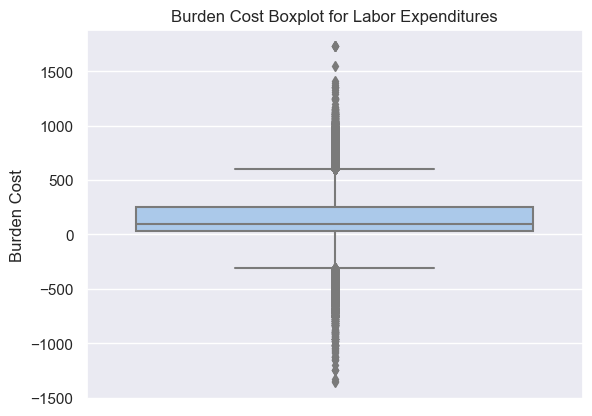

In [123]:
ax = sns.boxplot(y="burden_cost", data=labor.reset_index())
ax.set_ylabel("Burden Cost")
ax.set_title("Burden Cost Boxplot for Labor Expenditures")

c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


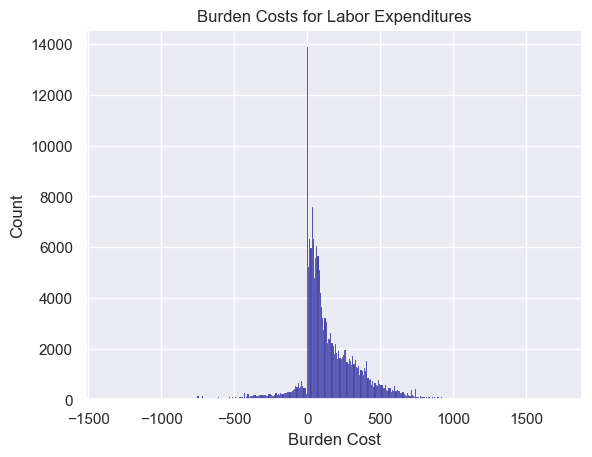

In [124]:
ax = sns.histplot(
    x="burden_cost",
    data=labor.reset_index(),
    color="darkblue",
)
ax.set_xlabel("Burden Cost")
ax.set_title("Burden Costs for Labor Expenditures")

plt.show()

Text(0.5, 1.0, 'Regular Time Boxplot for Labor Expenditures')

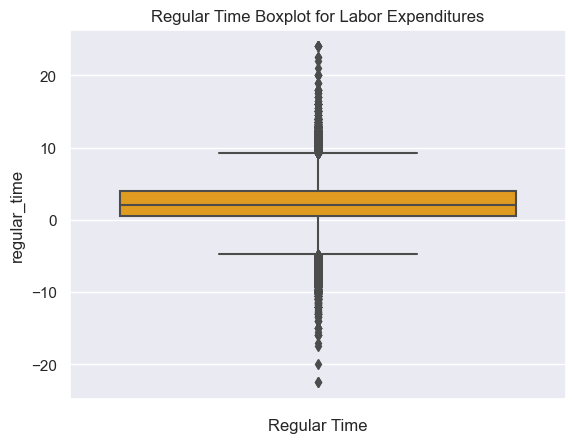

In [125]:
ax = sns.boxplot(y="regular_time", data=labor.reset_index(), color="orange")
ax.set_xlabel("Regular Time")
ax.set_title("Regular Time Boxplot for Labor Expenditures")

In [126]:
# ax = sns.histplot(
#     x="regular_time",
#     data=labor.reset_index(),
#     color="darkorange",
#     kde=True,
# )
# ax.set_xlabel("Regular Time")
# ax.set_title("Regular Time for Labor Expenditures")

# plt.show()

# Bivariate Analysis

In [127]:
burden_type_codes = df[(df["expenditure_category"] == "Burden")][
    "expenditure_type_code"
].value_counts(normalize=True)

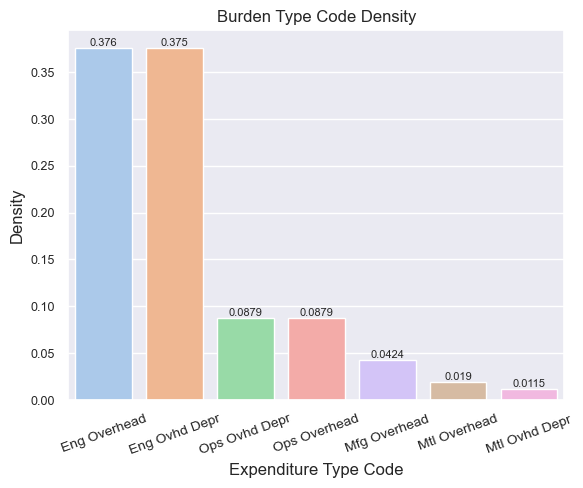

In [128]:
ax = plot_value_counts_density(
    grouped_counts=burden_type_codes,
    xlabel="Expenditure Type Code",
    title="Burden Type Code Density",
    barlabel_fontsize=8,
    xticklabel_fontsize=10,
    xticklabel_rotation=20,
)

plt.show()

Burden expenditures are all overhead/overhead depreciation.

In [129]:
cumul_labor_burden = get_grouped_cumsum(labor, "burden_cost", "expenditure_item_date")

c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Cumulative Labor Burden Cost')

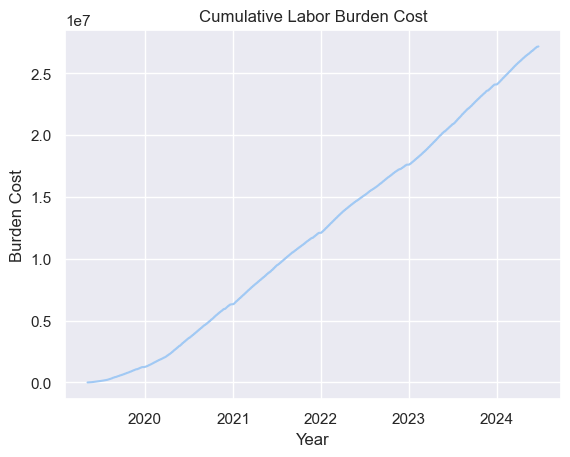

In [130]:
ax = sns.lineplot(cumul_labor_burden)
ax.set_xlabel("Year")
ax.set_ylabel("Burden Cost")
ax.set_title("Cumulative Labor Burden Cost")

c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Cumulative Labor Time')

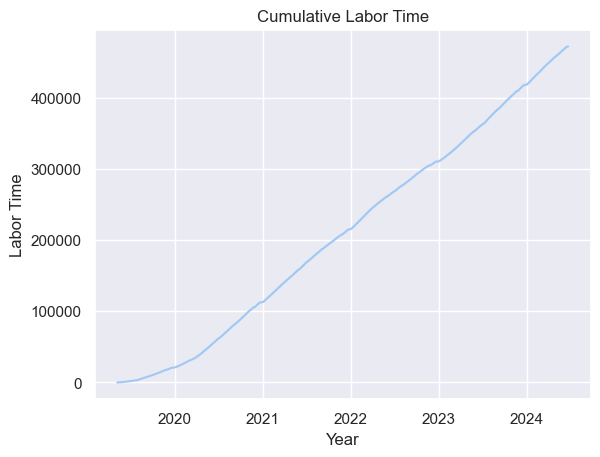

In [131]:
cumul_labor_time = get_grouped_cumsum(labor, "regular_time", "expenditure_item_date")
ax = sns.lineplot(cumul_labor_time)
ax.set_xlabel("Year")
ax.set_ylabel("Labor Time")
ax.set_title("Cumulative Labor Time")

c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Average Daily Labor Burden Cost')

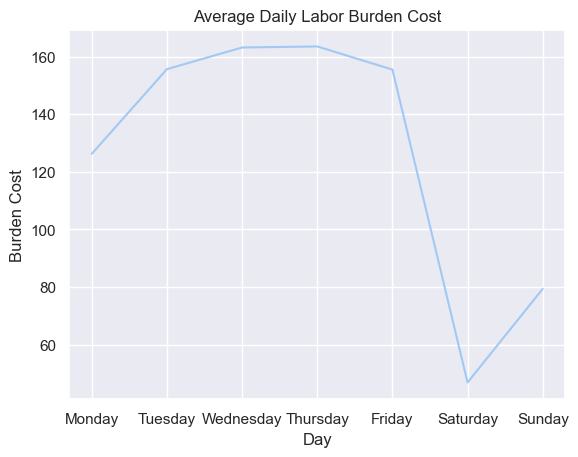

In [132]:
daily_avg_labor_burden = labor.groupby("day_of_week")["burden_cost"].mean()

ax = sns.lineplot(daily_avg_labor_burden)
days = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
ax.set_xticks(range(0, 7))
ax.set_xticklabels(days)

ax.set_xlabel("Day")
ax.set_ylabel("Burden Cost")
ax.set_title("Average Daily Labor Burden Cost")

c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Average Monthly Labor Burden Cost')

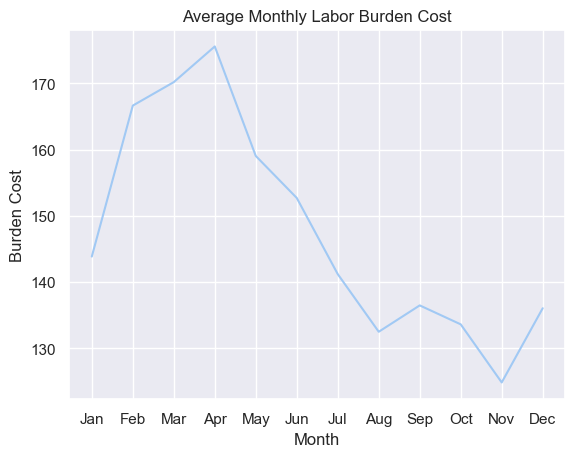

In [133]:
daily_avg_labor_burden = labor.groupby("month")["burden_cost"].mean()

ax = sns.lineplot(daily_avg_labor_burden)
month_labels = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_labels)
ax.set_xlabel("Month")
ax.set_ylabel("Burden Cost")
ax.set_title("Average Monthly Labor Burden Cost")

c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Average Daily Labor Expenditure Regular Time')

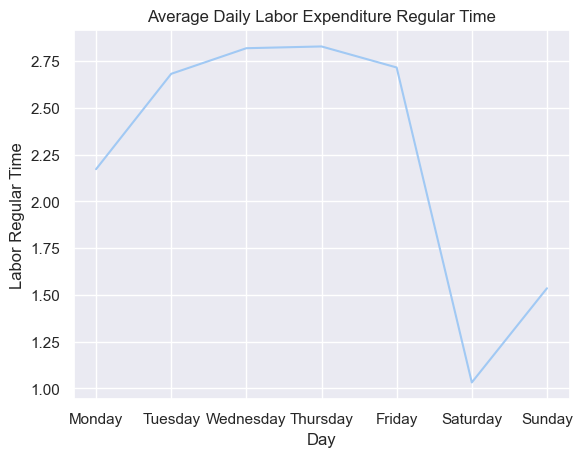

In [134]:
daily_avg_labor_time = labor.groupby("day_of_week")["regular_time"].mean()

ax = sns.lineplot(daily_avg_labor_time)
days = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
ax.set_xticks(range(0, 7))
ax.set_xticklabels(days)

ax.set_xlabel("Day")
ax.set_ylabel("Labor Regular Time")
ax.set_title("Average Daily Labor Expenditure Regular Time")

c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Average Monthly Labor Regular Time')

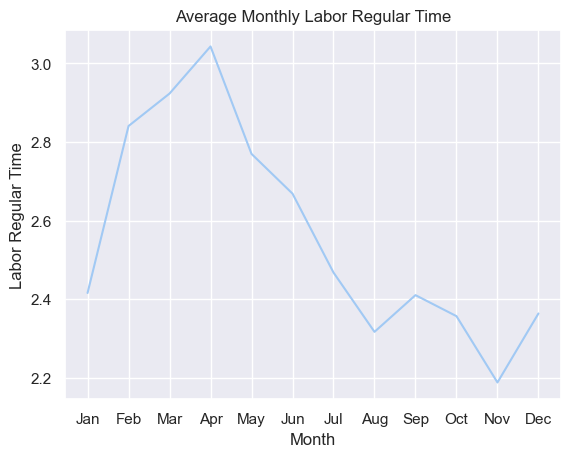

In [154]:
daily_avg_labor_burden = labor.groupby("month")["regular_time"].mean()

ax = sns.lineplot(daily_avg_labor_burden)
month_labels = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_labels)
ax.set_xlabel("Month")
ax.set_ylabel("Labor Regular Time")
ax.set_title("Average Monthly Labor Expenditure Regular Time")

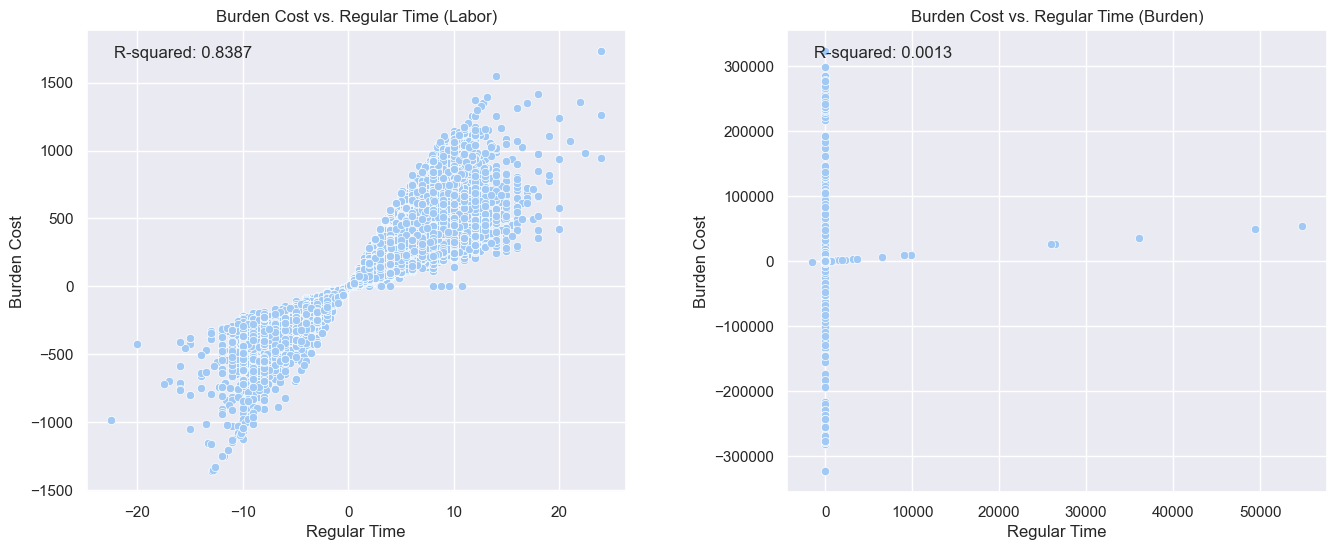

In [136]:
from scipy.stats import pearsonr

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))


labor_no_null_burden = labor.dropna(subset=["burden_cost", "regular_time"], how="any")
corr, _ = pearsonr(
    x=labor_no_null_burden["regular_time"], y=labor_no_null_burden["burden_cost"]
)

ax = sns.scatterplot(
    x="regular_time",
    y="burden_cost",
    data=labor,
    ax=axes[0],
)

plt.text(
    0.05,
    0.95,
    f"R-squared: {corr ** 2:.4f}",
    ha="left",
    va="center",
    transform=ax.transAxes,
)

ax.set_xlabel("Regular Time")
ax.set_ylabel("Burden Cost")
ax.set_title("Burden Cost vs. Regular Time (Labor)")


burden_no_null_burden = burden.dropna(subset=["burden_cost", "regular_time"], how="any")
corr, _ = pearsonr(
    x=burden_no_null_burden["regular_time"], y=burden_no_null_burden["burden_cost"]
)

ax = sns.scatterplot(
    x="regular_time",
    y="burden_cost",
    data=burden_no_null_burden,
    ax=axes[1],
)

plt.text(
    0.05,
    0.95,
    f"R-squared: {corr ** 2:.4f}",
    ha="left",
    va="center",
    transform=ax.transAxes,
)

ax.set_xlabel("Regular Time")
ax.set_ylabel("Burden Cost")
ax.set_title("Burden Cost vs. Regular Time (Burden)")

plt.subplots_adjust(wspace=0.3)
plt.show()

In [137]:
neg_burden_df = df[df["burden_cost"] < 0]
neg_time_df = df[df["regular_time"] < 0]

normal_burden_df = df[df["burden_cost"] >= 0]
normal_time_df = df[df["regular_time"] >= 0]

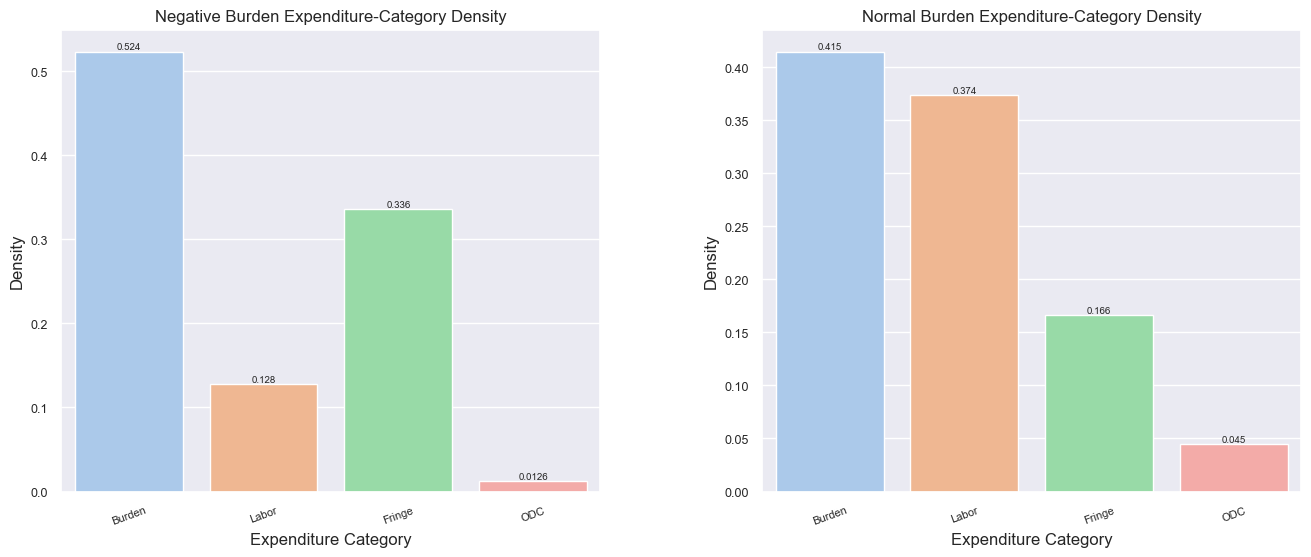

In [138]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

neg_burden_expenditure_counts = neg_burden_df["expenditure_category"].value_counts(
    normalize=True
)

plt.sca(axes[0])  # Set the current Axes to the first subplot

plot_value_counts_density(
    grouped_counts=neg_burden_expenditure_counts,
    xlabel="Expenditure Category",
    title="Negative Burden Expenditure-Category Density",
    barlabel_fontsize=7,
    xticklabel_fontsize=8,
    xticklabel_rotation=20,
    order=["Burden", "Labor", "Fringe", "ODC"],
)

normal_burden_expenditure_counts = normal_burden_df[
    "expenditure_category"
].value_counts(normalize=True)

plt.sca(axes[1])  # Set the current Axes to the second subplot

plot_value_counts_density(
    grouped_counts=normal_burden_expenditure_counts,
    xlabel="Expenditure Category",
    title="Normal Burden Expenditure-Category Density",
    barlabel_fontsize=7,
    xticklabel_fontsize=8,
    xticklabel_rotation=20,
    order=["Burden", "Labor", "Fringe", "ODC"],
)
plt.subplots_adjust(wspace=0.3)
plt.show()

posx and posy should be finite values
posx and posy should be finite values


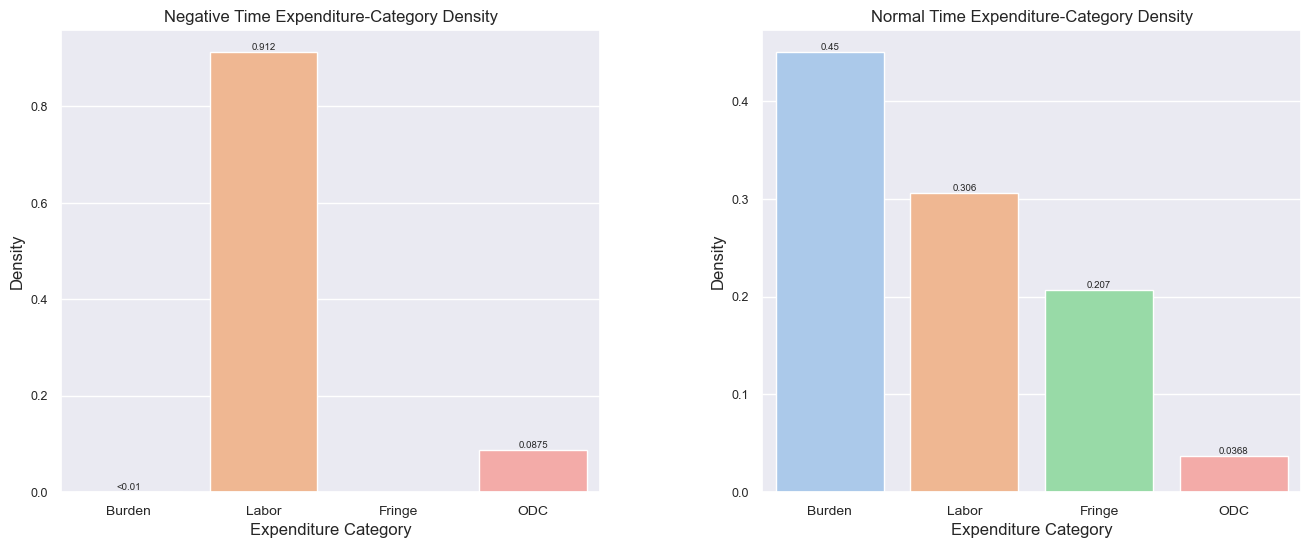

In [139]:
# Plots are confusing because scale and color orders are not the same.

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

neg_time_expenditure_counts = neg_time_df["expenditure_category"].value_counts(
    normalize=True
)

plt.sca(axes[0])  # Set the current Axes to the first subplot

palette_blo = sns.color_palette("pastel")
palette_blo[2] = palette_blo[3]


ax = plot_value_counts_density(
    grouped_counts=neg_time_expenditure_counts,
    xlabel="Expenditure Category",
    title="Negative Time Expenditure-Category Density",
    barlabel_fontsize=7,
    xticklabel_fontsize=10,
    xticklabel_rotation=0,
    order=["Burden", "Labor", "Fringe", "ODC"],
    palette=palette_blo,
)

normal_time_expenditure_counts = normal_time_df["expenditure_category"].value_counts(
    normalize=True
)

plt.sca(axes[1])  # Set the current Axes to the second subplot


ax = plot_value_counts_density(
    grouped_counts=normal_time_expenditure_counts,
    xlabel="Expenditure Category",
    title="Normal Time Expenditure-Category Density",
    barlabel_fontsize=7,
    xticklabel_fontsize=10,
    xticklabel_rotation=0,
)
plt.subplots_adjust(wspace=0.3)
plt.show()

In [140]:
neg_burden_labor = labor[(labor["burden_cost"] < 0)]
neg_burden_labor.shape[0]

15046

In [141]:
neg_burden_time_labor = neg_burden_labor[neg_burden_labor["regular_time"] < 0]
neg_burden_time_labor.shape[0]

15044

In [142]:
neg_burden_labor

,incurred_org,expenditure_comment,expenditure_category,item_description,expenditure_type_code,burden_cost,project_name,project_number,task_name,task_number,regular_time,month,day_of_week
expenditure_item_date,,,,,,,,,,,,,
2019-05-08,Eng - AS,None,Labor,None,Eng Labor,-494.24,Thunderbolt,0001899,HPA Competition-Ph 1,1.04.03.02,-8.0,5,2
2019-05-08,Eng - AS,None,Labor,None,Eng Labor,-456.48,Thunderbolt,0001899,Program Mgmt,1.04.01.01,-9.0,5,2
2019-05-08,Eng - AS,PCA coordination and training; WBS review; EVM...,Labor,None,Eng Labor,-370.20,Thunderbolt,0001899,Finance Mgmt Lead,1.04.04x.01,-5.0,5,2
2019-05-08,Eng - AS,None,Labor,None,Eng Labor,-235.52,Thunderbolt,0001899,Program Mgmt,1.04.01.01,-4.0,5,2
2019-05-08,Eng - AS,design,Labor,None,Eng Labor,-268.26,Thunderbolt,0001899,HPA Competition-Ph 1,1.04.03.02,-3.0,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24,Eng - AS,13m test status and punchlist items,Labor,None,Eng Labor,-121.72,Thunderbolt,0001899,13m PE,1.03.01.01.02,-1.0,5,4
2024-05-24,Eng - AS,24 FOC redline upates to Procedures (SAT),Labor,None,Eng Labor,-532.20,Thunderbolt,0001899,Engineering SDRLs,1.07.06.01.01,-6.0,5,4
2024-05-27,Ops - AS Manufacturing,None,Labor,None,Ops Labor,-221.44,Thunderbolt,0001899,24m FOC WIP Ant#2,1.01.01.06.02.01.07,-8.0,5,0


For labor expenditures that have a negative burden cost, almost all ALSO have negative regular_time.

In [143]:
neg_burden_labor[neg_burden_labor["regular_time"] >= 0]

,incurred_org,expenditure_comment,expenditure_category,item_description,expenditure_type_code,burden_cost,project_name,project_number,task_name,task_number,regular_time,month,day_of_week
expenditure_item_date,,,,,,,,,,,,,
2022-01-08,Eng - AS,remote support for testing,Labor,None,Eng Labor,-0.16,Swordfish Antennas,0001929,Proj Eng Ant#1,1120.1,8.0,1,5
2022-01-09,Eng - AS,test report documentation\r\ndry-run status re...,Labor,None,Eng Labor,-0.04,Swordfish Antennas,0001929,Proj Eng Ant#1,1120.1,2.0,1,6


In [144]:
neg_burden_labor["expenditure_comment"].value_counts()

expenditure_comment
PROJECT TRANSFERS                                                                                                                             2007
3458 prototype development                                                                                                                      55
Design for access hardware development                                                                                                          29
Thunderbolt IA support                                                                                                                          26
ECO processing                                                                                                                                  24
                                                                                                                                              ... 
gearing, reviewing skf/lincoln auto lubricating pinion.  starting to design gearing about that. re

In [145]:
neg_burden_labor[neg_burden_labor["expenditure_comment"] == "PROJECT TRANSFERS"][
    "project_name"
].value_counts()

project_name
Thunderbolt           1993
Swordfish Antennas      13
Riptide                  1
Name: count, dtype: int64

##### Accrued labor expenditures

In [146]:
accrued_labor = labor[labor["expenditure_type_code"].str.contains("Accrued")]

In [147]:
accrued_labor[accrued_labor["burden_cost"] < 0]

,incurred_org,expenditure_comment,expenditure_category,item_description,expenditure_type_code,burden_cost,project_name,project_number,task_name,task_number,regular_time,month,day_of_week
expenditure_item_date,,,,,,,,,,,,,
2019-07-20,Eng - AS,None,Labor,None,Eng Lbr Accrued,-449.26,Thunderbolt,0001899,Subcontracts Eng,1.04.03.03,-7.00,7,5
2019-07-22,Eng - AS,None,Labor,None,Eng Lbr Accrued,-256.72,Thunderbolt,0001899,Subcontracts Eng,1.04.03.03,-4.00,7,0
2019-07-23,Eng - AS,None,Labor,None,Eng Lbr Accrued,-256.72,Thunderbolt,0001899,Subcontracts Eng,1.04.03.03,-4.00,7,1
2019-07-28,Eng - AS,None,Labor,None,Eng Lbr Accrued,-119.24,Thunderbolt,0001899,Program Mgmt,1.04.01.01,-2.00,7,6
2019-07-29,Eng - AS,None,Labor,None,Eng Lbr Accrued,-78.24,Thunderbolt,0001899,24m Project Engineer,1.03.01.03,-1.50,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,Eng - GSN System Int & Test Government,None,Labor,None,Eng Lbr Accrued,-35.24,Thunderbolt,0001899,Install Eng Support,1.10.01.01.06,-0.50,4,1
2024-04-30,Ops - AS Operations Management,None,Labor,None,Ops Lbr Accrued,-398.07,Thunderbolt,0001899,24m FOC Destack,1.05.01.01.04,-9.00,4,1
2024-04-30,Eng - GSN System Int & Test Government,None,Labor,None,Eng Lbr Accrued,-522.06,Swordfish Antennas,0001929,"Install, Integration",4220,-11.00,4,1


In [148]:
accrued_labor["expenditure_comment"].value_counts()

expenditure_comment
SUBMITTED    2745
WORKING      2290
Name: count, dtype: int64

In [149]:
(accrued_labor["burden_cost"] < 0).mean()

0.4986058554072894

Text(0.5, 1.0, 'Accrued Labor Time and Burden Cost By Expenditure Comment')

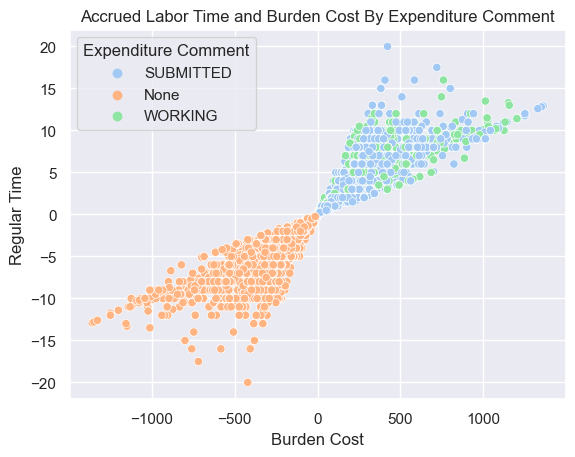

In [150]:
sns.scatterplot(
    x="burden_cost",
    y="regular_time",
    hue="expenditure_comment",
    data=accrued_labor.fillna("None"),
    legend=True,
)

plt.legend(title="Expenditure Comment")
plt.ylabel("Regular Time")
plt.xlabel("Burden Cost")
plt.title("Accrued Labor Time and Burden Cost By Expenditure Comment")

plt.legend(title="Expenditure Comment")
plt.ylabel("Regular Time")
plt.xlabel("Burden Cost")
plt.title("Accrued Labor Time and Burden Cost By Expenditure Comment")

In [153]:
accrued_labor[accrued_labor["expenditure_comment"] == "SUBMITTED"]

,incurred_org,expenditure_comment,expenditure_category,item_description,expenditure_type_code,burden_cost,project_name,project_number,task_name,task_number,regular_time,month,day_of_week
expenditure_item_date,,,,,,,,,,,,,
2019-07-20,Eng - AS,SUBMITTED,Labor,None,Eng Lbr Accrued,449.26,Thunderbolt,0001899,Subcontracts Eng,1.04.03.03,7.0,7,5
2019-07-22,Eng - AS,SUBMITTED,Labor,None,Eng Lbr Accrued,256.72,Thunderbolt,0001899,Subcontracts Eng,1.04.03.03,4.0,7,0
2019-07-23,Eng - AS,SUBMITTED,Labor,None,Eng Lbr Accrued,256.72,Thunderbolt,0001899,Subcontracts Eng,1.04.03.03,4.0,7,1
2019-07-28,Eng - AS,SUBMITTED,Labor,None,Eng Lbr Accrued,119.24,Thunderbolt,0001899,Program Mgmt,1.04.01.01,2.0,7,6
2019-07-29,Eng - AS,SUBMITTED,Labor,None,Eng Lbr Accrued,79.57,Thunderbolt,0001899,Cost Plus RFP Quote,1.04.12.01,1.0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,Eng - GSN System Int & Test Government,SUBMITTED,Labor,None,Eng Lbr Accrued,60.37,Riptide,0001949,Software Support,9300.2,1.0,5,4
2024-05-31,Ops - VP Carlsbad,SUBMITTED,Labor,None,Ops Lbr Accrued,280.88,Thunderbolt,0001899,24m Tiger Team Sppt,1.04.03.01.12,2.0,5,4
2024-05-31,Ops - VP Carlsbad,SUBMITTED,Labor,None,Ops Lbr Accrued,280.88,Thunderbolt,0001899,13m Tiger Team Sppt,1.04.03.01.13,2.0,5,4
